## Abedin Sherifi <br>
## Cardano ADA Regression Analysis <br>
## Data Analysis 

In [28]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [29]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return pd.DataFrame(df,columns=result).to_numpy(dtype=np.float32), dummies.to_numpy(dtype=np.float32)
    else:
        # Regression
        return pd.DataFrame(df,columns=result).to_numpy(dtype=np.float32), pd.DataFrame(df,columns=[target]).to_numpy(dtype=np.float32)


# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [30]:
df = pd.read_csv('coin_Cardano.csv',na_values=['NA','?'])

In [31]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Cardano,ADA,2017-10-02 23:59:59,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
1,2,Cardano,ADA,2017-10-03 23:59:59,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2,3,Cardano,ADA,2017-10-04 23:59:59,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
3,4,Cardano,ADA,2017-10-05 23:59:59,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
4,5,Cardano,ADA,2017-10-06 23:59:59,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        1245 non-null   int64  
 1   Name       1245 non-null   object 
 2   Symbol     1245 non-null   object 
 3   Date       1245 non-null   object 
 4   High       1245 non-null   float64
 5   Low        1245 non-null   float64
 6   Open       1245 non-null   float64
 7   Close      1245 non-null   float64
 8   Volume     1245 non-null   float64
 9   Marketcap  1245 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 97.4+ KB


In [33]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Cardano,ADA,2017-10-02 23:59:59,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
1,2,Cardano,ADA,2017-10-03 23:59:59,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2,3,Cardano,ADA,2017-10-04 23:59:59,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
3,4,Cardano,ADA,2017-10-05 23:59:59,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
4,5,Cardano,ADA,2017-10-06 23:59:59,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


In [34]:
df.Date = df.Date.str.replace('-','')
df['Date'] = df['Date'].str.split(' ').str[0]

In [35]:
df['Date'] = df['Date'].astype('int64')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        1245 non-null   int64  
 1   Name       1245 non-null   object 
 2   Symbol     1245 non-null   object 
 3   Date       1245 non-null   int64  
 4   High       1245 non-null   float64
 5   Low        1245 non-null   float64
 6   Open       1245 non-null   float64
 7   Close      1245 non-null   float64
 8   Volume     1245 non-null   float64
 9   Marketcap  1245 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 97.4+ KB


In [37]:
df.shape

(1245, 10)

In [38]:
df.describe()

,SNo,Date,High,Low,Open,Close,Volume,Marketcap
count,1245.000000,1.245000e+03,1245.000000,1245.000000,1245.000000,1245.000000,1.245000e+03,1.245000e+03
mean,623.000000,2.019016e+07,0.146055,0.129342,0.137758,0.138757,4.729622e+08,3.788101e+09
std,359.544851,1.021154e+04,0.190901,0.159500,0.174933,0.177812,1.427985e+09,5.099696e+09
min,1.000000,2.017100e+07,0.021050,0.017620,0.018414,0.018539,1.739460e+06,4.806646e+08
25%,312.000000,2.018081e+07,0.045570,0.042981,0.044286,0.044328,4.642072e+07,1.149308e+09
50%,623.000000,2.019062e+07,0.083514,0.077631,0.080869,0.080952,1.011906e+08,2.102088e+09
75%,934.000000,2.020042e+07,0.149314,0.138102,0.143086,0.143573,2.576860e+08,3.779666e+09
max,1245.000000,2.021023e+07,1.476653,1.234138,1.242145,1.324860,1.914198e+10,4.121970e+10


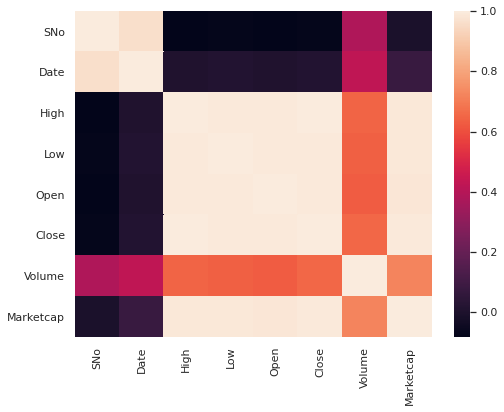

In [39]:
plt.figure(figsize=(8,6))
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [40]:
df.drop_duplicates(subset='Date')

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Cardano,ADA,20171002,0.030088,0.019969,0.024607,0.025932,5.764130e+07,6.288991e+08
1,2,Cardano,ADA,20171003,0.027425,0.020690,0.025757,0.020816,1.699780e+07,5.396927e+08
2,3,Cardano,ADA,20171004,0.022806,0.020864,0.020864,0.021931,9.000050e+06,5.686195e+08
3,4,Cardano,ADA,20171005,0.022154,0.020859,0.021951,0.021489,5.562510e+06,5.571390e+08
4,5,Cardano,ADA,20171006,0.021542,0.018360,0.021359,0.018539,7.780710e+06,4.806646e+08
...,...,...,...,...,...,...,...,...,...,...
1240,1241,Cardano,ADA,20210223,1.133705,0.824145,1.098769,0.954709,1.120190e+10,2.970337e+10
1241,1242,Cardano,ADA,20210224,1.074832,0.902583,0.954958,1.051657,8.481335e+09,3.271965e+10
1242,1243,Cardano,ADA,20210225,1.172732,1.017986,1.051349,1.079116,8.248286e+09,3.357399e+10
1243,1244,Cardano,ADA,20210226,1.290047,0.995150,1.080828,1.241105,1.488414e+10,3.861387e+10


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Date', ylabel='Close'>

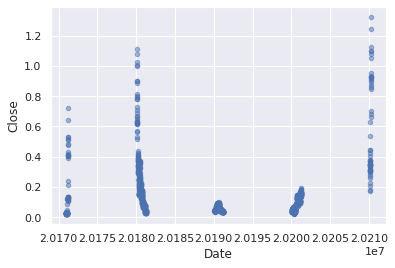

In [41]:
df.plot(x='Date', y='Close', kind='scatter', alpha=0.5)

In [42]:
df.isna().any()

SNo          False
Name         False
Symbol       False
Date         False
High         False
Low          False
Open         False
Close        False
Volume       False
Marketcap    False
dtype: bool

<AxesSubplot:>

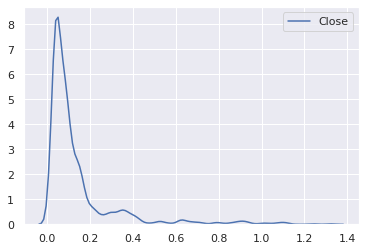

In [43]:
closee = df['Close']
sns.kdeplot(data=closee)

<AxesSubplot:xlabel='Close'>

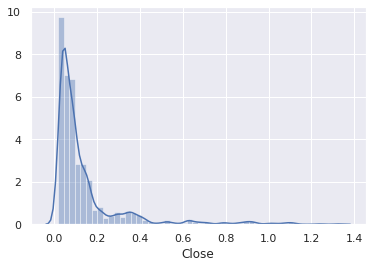

In [44]:
sns.distplot(df['Close'])

In [45]:
df.drop('SNo',1,inplace=True)
df.head()

,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,Cardano,ADA,20171002,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
1,Cardano,ADA,20171003,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2,Cardano,ADA,20171004,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
3,Cardano,ADA,20171005,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
4,Cardano,ADA,20171006,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


/home/dino/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


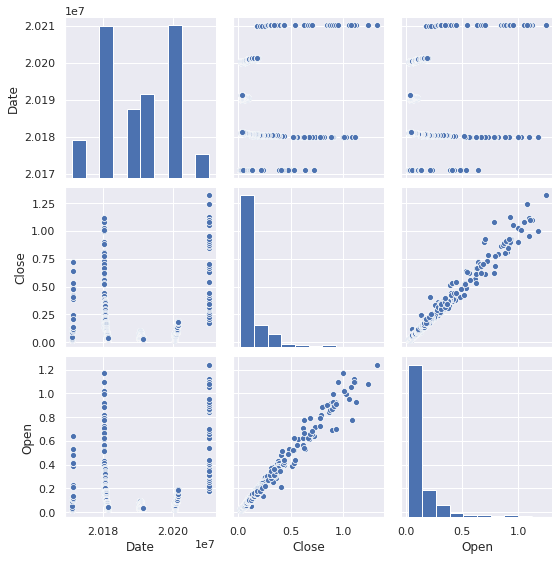

In [46]:
sns.set()
cols = ['Date', 'Close', 'Open']
sns.pairplot(df[cols], size = 2.5)
plt.show();

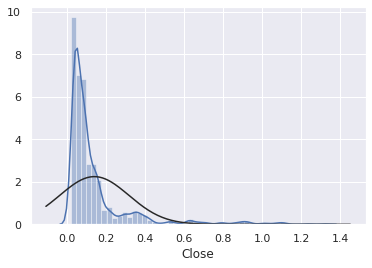

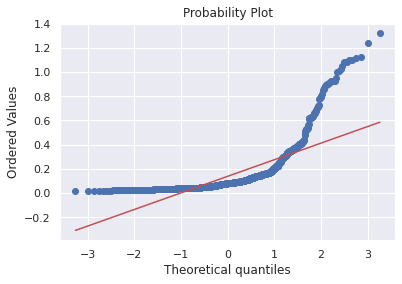

In [47]:
#histogram and normal probability plot
from scipy import stats
sns.distplot(df['Close'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(df['Close'], plot=plt)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       1245 non-null   object 
 1   Symbol     1245 non-null   object 
 2   Date       1245 non-null   int64  
 3   High       1245 non-null   float64
 4   Low        1245 non-null   float64
 5   Open       1245 non-null   float64
 6   Close      1245 non-null   float64
 7   Volume     1245 non-null   float64
 8   Marketcap  1245 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 87.7+ KB


In [22]:
df.drop('Name',1,inplace=True)
df.drop('Symbol',1,inplace=True)

In [49]:
df

,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,Cardano,ADA,20171002,0.030088,0.019969,0.024607,0.025932,5.764130e+07,6.288991e+08
1,Cardano,ADA,20171003,0.027425,0.020690,0.025757,0.020816,1.699780e+07,5.396927e+08
2,Cardano,ADA,20171004,0.022806,0.020864,0.020864,0.021931,9.000050e+06,5.686195e+08
3,Cardano,ADA,20171005,0.022154,0.020859,0.021951,0.021489,5.562510e+06,5.571390e+08
4,Cardano,ADA,20171006,0.021542,0.018360,0.021359,0.018539,7.780710e+06,4.806646e+08
...,...,...,...,...,...,...,...,...,...
1240,Cardano,ADA,20210223,1.133705,0.824145,1.098769,0.954709,1.120190e+10,2.970337e+10
1241,Cardano,ADA,20210224,1.074832,0.902583,0.954958,1.051657,8.481335e+09,3.271965e+10
1242,Cardano,ADA,20210225,1.172732,1.017986,1.051349,1.079116,8.248286e+09,3.357399e+10
1243,Cardano,ADA,20210226,1.290047,0.995150,1.080828,1.241105,1.488414e+10,3.861387e+10


In [50]:
encode_numeric_zscore(df, 'Volume')
encode_numeric_zscore(df, 'Marketcap')
encode_numeric_zscore(df, 'Date')

In [51]:
df

,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,Cardano,ADA,-1.875632,0.030088,0.019969,0.024607,0.025932,-0.290844,-0.619488
1,Cardano,ADA,-1.875534,0.027425,0.020690,0.025757,0.020816,-0.319306,-0.636981
2,Cardano,ADA,-1.875436,0.022806,0.020864,0.020864,0.021931,-0.324907,-0.631309
3,Cardano,ADA,-1.875338,0.022154,0.020859,0.021951,0.021489,-0.327314,-0.633560
4,Cardano,ADA,-1.875240,0.021542,0.018360,0.021359,0.018539,-0.325761,-0.648556
...,...,...,...,...,...,...,...,...,...
1240,Cardano,ADA,1.965221,1.133705,0.824145,1.098769,0.954709,7.513343,5.081729
1241,Cardano,ADA,1.965319,1.074832,0.902583,0.954958,1.051657,5.608165,5.673191
1242,Cardano,ADA,1.965417,1.172732,1.017986,1.051349,1.079116,5.444964,5.840718
1243,Cardano,ADA,1.965515,1.290047,0.995150,1.080828,1.241105,10.091972,6.828989


In [61]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from keras.layers import Dropout


df.drop('Name',1,inplace=True)
df.drop('Symbol',1,inplace=True)
#encode_numeric_zscore(df, 'Volume')
#encode_numeric_zscore(df, 'Marketcap')
x,y = to_xy(df,'Close')
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=2,epochs=100)

Epoch 1/100
 - 0s - loss: 0.0162
Epoch 2/100
 - 0s - loss: 7.8456e-04
Epoch 3/100
 - 0s - loss: 4.8932e-04
Epoch 4/100
 - 0s - loss: 1.5084e-04
Epoch 5/100
 - 0s - loss: 1.4124e-04
Epoch 6/100
 - 0s - loss: 7.7194e-05
Epoch 7/100
 - 0s - loss: 6.2037e-05
Epoch 8/100
 - 0s - loss: 5.8209e-05
Epoch 9/100
 - 0s - loss: 5.0084e-05
Epoch 10/100
 - 0s - loss: 4.6099e-05
Epoch 11/100
 - 0s - loss: 4.6319e-05
Epoch 12/100
 - 0s - loss: 3.8378e-05
Epoch 13/100
 - 0s - loss: 3.6503e-05
Epoch 14/100
 - 0s - loss: 3.6034e-05
Epoch 15/100
 - 0s - loss: 4.0668e-05
Epoch 16/100
 - 0s - loss: 3.3536e-05
Epoch 17/100
 - 0s - loss: 3.5781e-05
Epoch 18/100
 - 0s - loss: 2.7139e-05
Epoch 19/100
 - 0s - loss: 3.0862e-05
Epoch 20/100
 - 0s - loss: 2.6971e-05
Epoch 21/100
 - 0s - loss: 2.7964e-05
Epoch 22/100
 - 0s - loss: 2.5089e-05
Epoch 23/100
 - 0s - loss: 1.9825e-05
Epoch 24/100
 - 0s - loss: 2.3606e-05
Epoch 25/100
 - 0s - loss: 2.0706e-05
Epoch 26/100
 - 0s - loss: 2.6850e-05
Epoch 27/100
 - 0s - loss

In [62]:
pred = model.predict(x)
print("Shape: {}".format(pred.shape))
print(pred)

Shape: (1245, 1)
[[0.01866377]
 [0.0141762 ]
 [0.01490614]
 ...
 [1.0875826 ]
 [1.223474  ]
 [1.3485312 ]]


In [63]:
x.shape

(1245, 6)

In [64]:
df['pred'] = pred

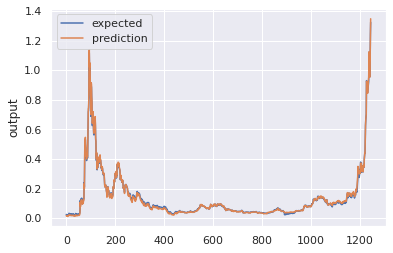

In [65]:
chart_regression(pred.flatten(),y, sort=False)

In [66]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.007158439140766859


In [67]:
# Sample predictions
for i in range(10):
    print("{}. Close: {}, predicted Close: {}".format(i+1,y[i],pred[i]))

1. Close: [0.0259318], predicted Close: [0.01866377]
2. Close: [0.0208158], predicted Close: [0.0141762]
3. Close: [0.0219315], predicted Close: [0.01490614]
4. Close: [0.0214887], predicted Close: [0.01450209]
5. Close: [0.0185391], predicted Close: [0.01237602]
6. Close: [0.0209409], predicted Close: [0.01442138]
7. Close: [0.0204772], predicted Close: [0.01357895]
8. Close: [0.0221137], predicted Close: [0.01495693]
9. Close: [0.0215313], predicted Close: [0.01435667]
10. Close: [0.0225195], predicted Close: [0.01528808]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Date', ylabel='pred'>

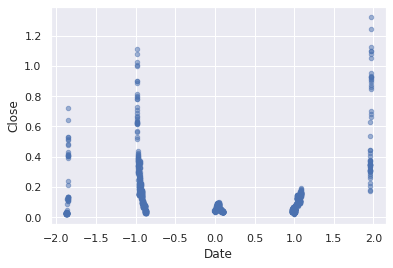

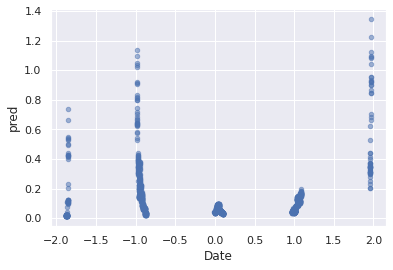

In [68]:
df.plot(x='Date', y='Close', kind='scatter', alpha=0.5)
df.plot(x='Date', y='pred', kind='scatter', alpha=0.5)